# Problem Definition

Given historical wind speed data at a certain location, the task is to build a model that can accurately predict the wind speed at that location for a future time period.

#Import necessary packages

In [ ]:
import warnings
warnings.filterwarnings("ignore") # to suppress warning messages
import pandas as pd # to manipulate the dataset
import numpy as np # for numerical computaion and array manipulation
import matplotlib.pyplot as plt # for data visualization
import statsmodels.tsa.stattools as sts # for statistical tools fot time series
from statsmodels.tsa.seasonal import seasonal_decompose # to chech seasonality
from statsmodels.tsa.arima.model import ARIMA # arma model
import statsmodels.graphics.tsaplots as sgt #plot acf and pacf
from scipy.stats.distributions import chi2
from statsmodels.tsa.statespace.sarimax import SARIMAX # import sarima
from sklearn.metrics import mean_squared_error # import mean square error
import seaborn as sns # for enhance the visual apeal of matplotlib graghs
import pmdarima as pm # for autoarima
from math import sqrt
import itertools
sns.set(style="darkgrid")


In [ ]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.8 MB/s eta 0:00:00


#Load the data set

In [ ]:
#load the data
data = pd.read_csv("/content/drive/MyDrive/wind_dataset.csv")
# take copy
df = data.copy()
#visualize the first 5 rows
df.head()

,DATE,WIND,IND,RAIN,IND.1,T.MAX,IND.2,T.MIN,T.MIN.G
0,1961-01-01,13.67,0,0.2,0.0,9.5,0.0,3.7,-1.0
1,1961-01-02,11.50,0,5.1,0.0,7.2,0.0,4.2,1.1
2,1961-01-03,11.25,0,0.4,0.0,5.5,0.0,0.5,-0.5
3,1961-01-04,8.63,0,0.2,0.0,5.6,0.0,0.4,-3.2
4,1961-01-05,11.92,0,10.4,0.0,7.2,1.0,-1.5,-7.5


#EDA(Exploratory Data Analysis):

In [ ]:
# num of rows and columns
df.shape

(6574, 9)

We have   daily measurments (6574 rows in total) of wind, rain,maximum,minimum and ground truth as well as some other indicator variables.

In [ ]:
# num of rows and columns
print ("Number of Rows : " ,df.shape[0])
print ("Number of Columns : " ,df.shape[1])
# missing values:
print("="*100,"\nNumber of missing values for every column: \n", df.isna().sum())
print ("="*100,"\nduplicate values : \n",df.duplicated().sum())

Number of Rows :  6574
Number of Columns :  9
Number of missing values for every column: 
 DATE         0
WIND         0
IND          0
RAIN         0
IND.1       61
T.MAX      621
IND.2       61
T.MIN      674
T.MIN.G    360
dtype: int64
duplicate values : 
 0


We don't have missing values in our target column

In [ ]:
#check the type of the columns
df.dtypes

DATE        object
WIND       float64
IND          int64
RAIN       float64
IND.1      float64
T.MAX      float64
IND.2      float64
T.MIN      float64
T.MIN.G    float64
dtype: object

The date column is an object type so will convert it to datetime.

##Data preprocessing

In [ ]:
#transform DATE column
df["DATE"]= pd.to_datetime(df["DATE"])
#set date as an index
df.set_index("DATE", inplace=True)
# set frequency of the index
df = df.asfreq(pd.infer_freq(df.index))

In [ ]:
df.head()

,WIND,IND,RAIN,IND.1,T.MAX,IND.2,T.MIN,T.MIN.G
DATE,,,,,,,,
1961-01-01,13.67,0,0.2,0.0,9.5,0.0,3.7,-1.0
1961-01-02,11.50,0,5.1,0.0,7.2,0.0,4.2,1.1
1961-01-03,11.25,0,0.4,0.0,5.5,0.0,0.5,-0.5
1961-01-04,8.63,0,0.2,0.0,5.6,0.0,0.4,-3.2
1961-01-05,11.92,0,10.4,0.0,7.2,1.0,-1.5,-7.5


##Data visualization

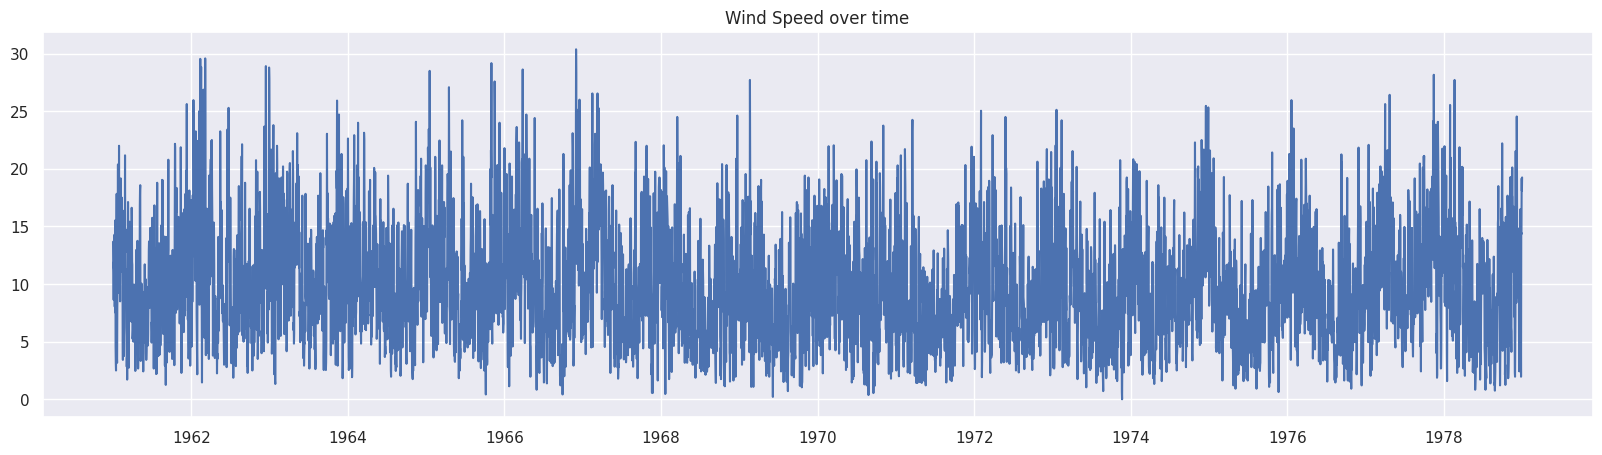

In [ ]:
#plot the wind speed
plt.figure(figsize=(20,5))
plt.plot(df["WIND"])
plt.title("Wind Speed over time")
plt.show();



There is no clear upward or dawnward trend. the time series seems stationary.

In [ ]:
# for simplicity reasons, keep only last year
# also, remove variables with "IND" to focus on the numerical ones
df = df[df.index >= '1978-01-01']
df = df[['WIND','RAIN','T.MAX','T.MIN','T.MIN.G']]
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 1978-01-01 to 1978-12-31
Freq: D
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   WIND     365 non-null    float64
 1   RAIN     365 non-null    float64
 2   T.MAX    362 non-null    float64
 3   T.MIN    362 non-null    float64
 4   T.MIN.G  359 non-null    float64
dtypes: float64(5)
memory usage: 17.1 KB


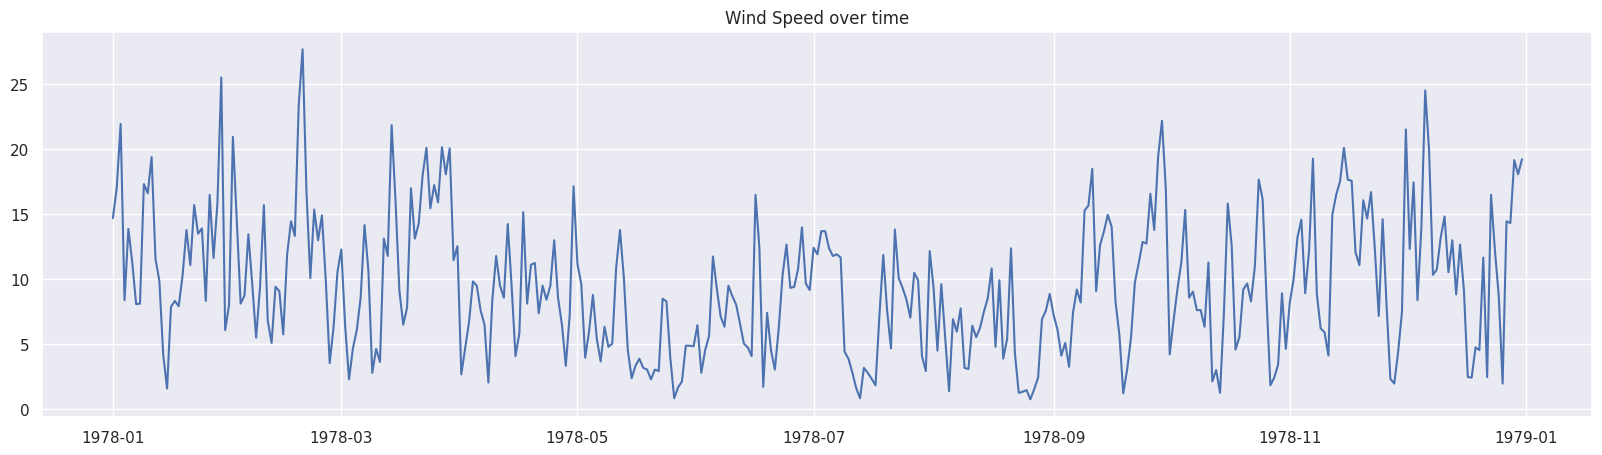

In [ ]:
#plot the wind speed
plt.figure(figsize=(20,5))
plt.plot(df["WIND"])
plt.title("Wind Speed over time")
plt.show();

Upon analyzing the wind speed dataset, it appears that there is a noticeable increase in wind speed during the months of January through April. This trend is consistent with the typical climatic pattern where wind speeds are generally higher in winter. Conversely, from May to September, there is a marked decrease in wind speed, aligning with the calmer atmospheric conditions usually observed in summer. Despite these seasonal fluctuations, the time series appears to be stationary. This suggests that while the wind speed varies seasonally, these variations are consistent over time, maintaining a constant mean and variance. Therefore, the dataset exhibits both seasonality and stationarity.

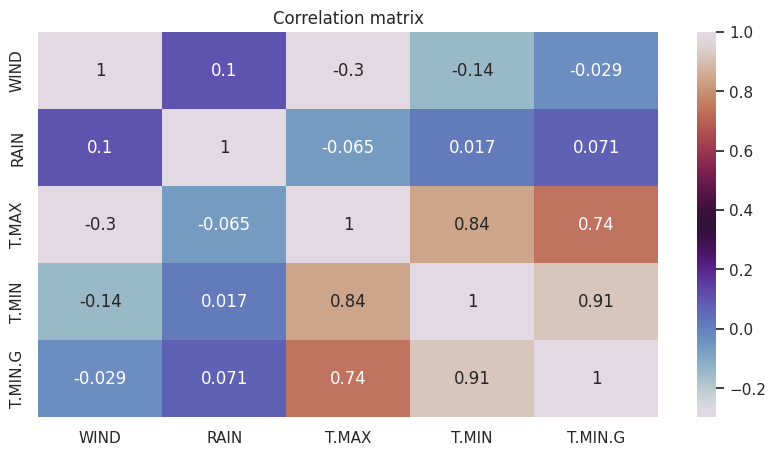

In [ ]:
#measure the correlation
plt.figure(figsize=(10,5))
sns.heatmap(df.corr(),annot=True,cmap="twilight")
plt.title("Correlation matrix")
plt.show();

well, wind speed dosen't seem to have a stong correlation with other variables.

### Check stationarity

In [ ]:
sts.adfuller(df["WIND"])

(-7.230740163440082,
 1.9977742477580708e-10,
 2,
 362,
 {'1%': -3.448544133483233,
  '5%': -2.8695574079525565,
  '10%': -2.5710411593052713},
 1983.5135608110395)

The p-value is less than a chosen significance level (e.g. 0.05), we reject the null hypothesis and consider that Time Series is stationary.

### Check seasonality

In [ ]:
result = seasonal_decompose(df["WIND"], model="multiplicative")
trend = result.trend
seasonal = result.seasonal
residuals= result.resid

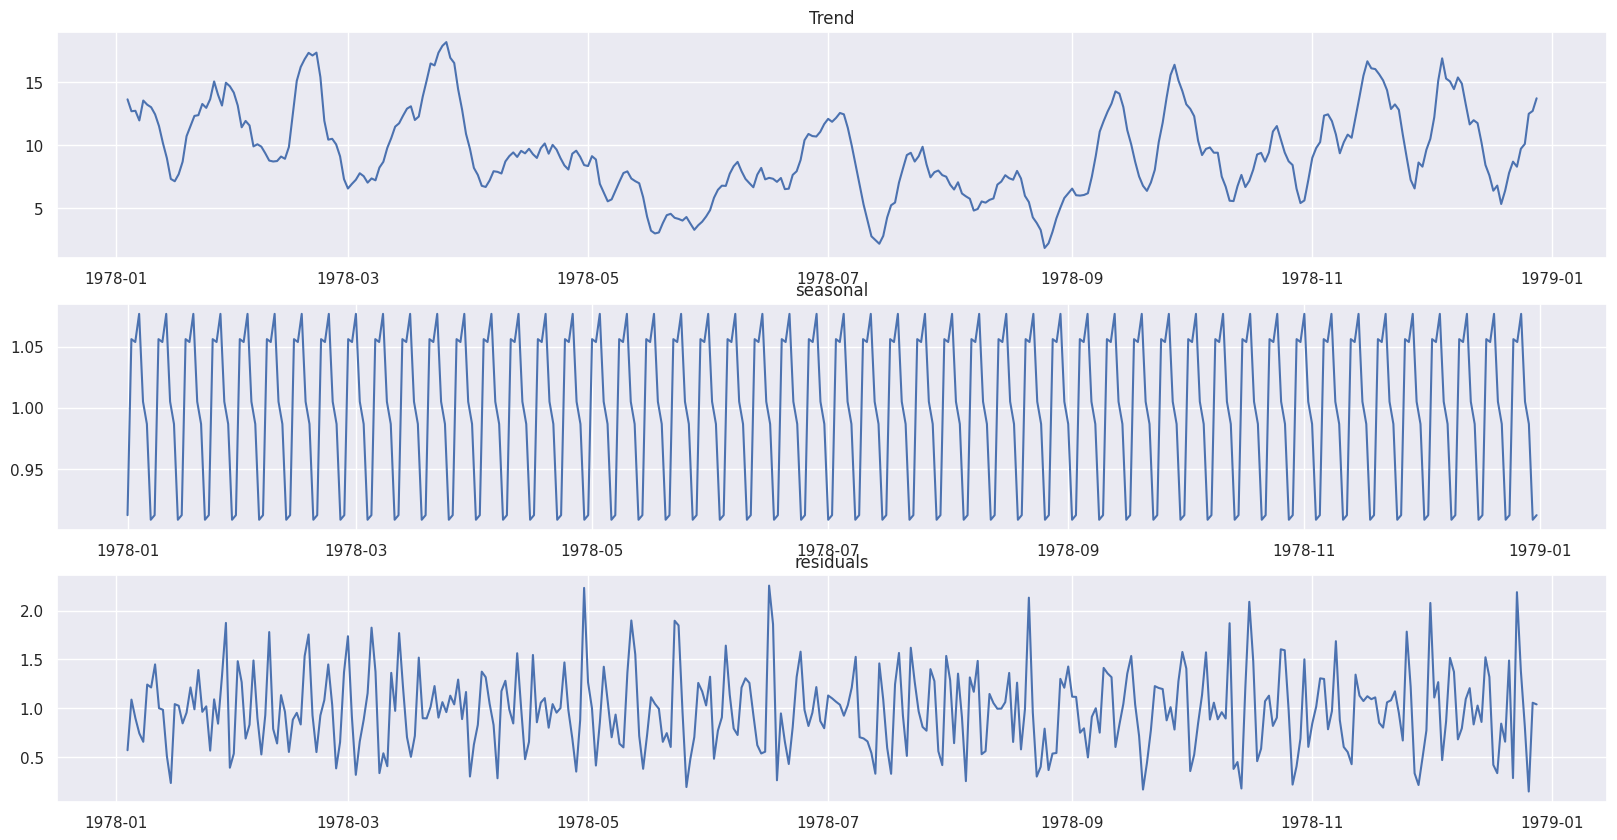

In [ ]:
plt.figure(figsize=(20,10))

#plot trend
plt.subplot(311)
plt.plot(trend)
plt.title("Trend")
# plot seasonal
plt.subplot(312)
plt.plot(seasonal)
plt.title("seasonal")
#plot residuals
plt.subplot(313)
plt.plot(residuals)
plt.title('residuals');




The data appears to be stationary as it does not exhibit a clear upward or downward trend over time. Instead, it oscillates in a consistent pattern, indicating seasonality.

Upon closer inspection, we observe approximately 8 peaks every 3 months (or about every 90 days). This suggests a seasonality of more than 7 days. This information is crucial when selecting the parameters of our SARIMA model.

Given this, the seasonal period s in the SARIMA model would likely fall between 8 to 11. However, this is an initial estimate and may need to be refined based on further analysis.

To determine the seasonal autoregressive order P and the seasonal moving average order Q, we will examine the Partial Autocorrelation Function (PACF) and Autocorrelation Function (ACF) plots respectively. Specifically, we will look for significant lags at the seasonal period s.


###Examine ACF and PACF

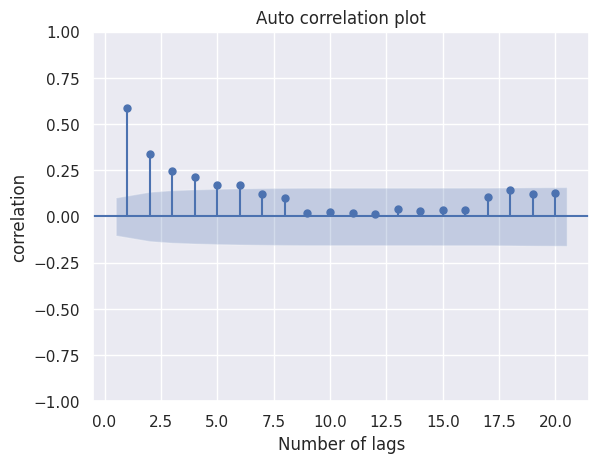

In [ ]:
# plot ACF
sgt.plot_acf(df["WIND"],zero=False,lags=20)
plt.xlabel("Number of lags")
plt.ylabel("correlation")
plt.title("Auto correlation plot")
plt.show();

The ACF plot shows significant autocorrelation for the first six lags.This suggests that the current value of the series influenced by its six value periods ago.
the autocorrelation the drop off , which indicates that the series dosn't depend on values beyond six periods ago. This could be an indication of moving average process (q) of order six. However, further analysis would be needed to confirm this.



From the ACF plot, we can infer that the seasonal moving average order Q in the SARIMA model could be zero. This is because there are no significant autocorrelations at the seasonal lags (from 8 to 11). This suggests that there may not be a seasonal moving average component in the model.

However, this is an initial estimate and may need to be refined based on further analysis. It’s always a good idea to try different orders and compare the model’s performance.

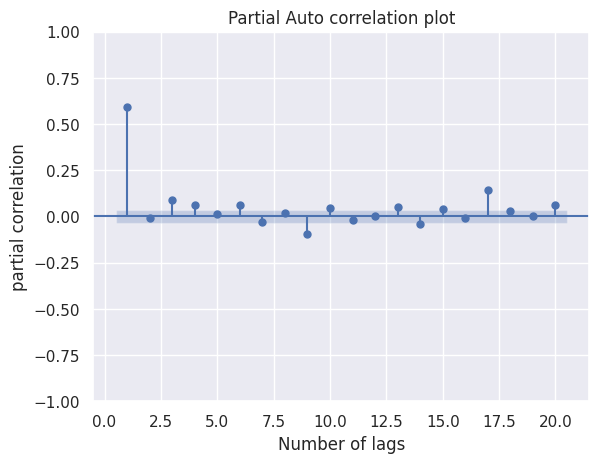

In [ ]:
#Examine PACF
sgt.plot_pacf(df["WIND"],zero=False,lags=20,alpha=0.5,method=('ols'))
plt.xlabel("Number of lags")
plt.ylabel("partial correlation")
plt.title("Partial Auto correlation plot")
plt.show();

PACF shows significant autocorrelation with the first lag.
this means that the current value only influenced by the previous period.
From this pattern we can conclude the order of autoregressive  component (p)  is one.

· p = last lag where the PACF value is out of the significance band (displayed by the confidence interval).

· q = last lag where the ACF value is out of the significance band (displayed by the confidence interval).

From the PACF plot, we can infer that the seasonal autoregressive order P in the SARIMA model could be 1 or 2. This is because there are significant partial autocorrelations at the seasonal lags 9 and 17. This suggests that there may be a seasonal autoregressive component in the model.

However, this is an initial estimate and may need to be refined based on further analysis. It’s always a good idea to try different orders and compare the model’s performance.

#Modeling

###Split the dataset



This dataset is a time series data. Becaues it's in chronological order we can’t split it using the train-test split function in sklearn. Instead, we will use a cut-off point. We will use the data up to this point as a training data and the rest will be our test.

In [ ]:
cutoff_test  = 10
train= df[:-cutoff_test]
test= df[-cutoff_test:]
print('training set (past data): ', len(train))
print('test set (days to be forecasted ahead): ', len(test))

training set (past data):  355
test set (days to be forecasted ahead):  10


###ARMA

Based on the prior analysis,the dataset appears to be stationary, making it a good canditate for ARMA model. The ACF and PACF plots suggests that an ARMA(1,6) would be appropriate.  However, to ensure we’re not overcomplicating the model, I’ll also experiment with simpler models. We’ll use the Likelihood Ratio (LLR) test to see if the additional complexity of the ARMA(1,6) model significantly improves performance.


I’ve also observed some seasonality in the dataset. To account for this, I’ll explore the SARIMA model, which is designed to handle seasonal data. After fitting both the ARMA and SARIMA models, I’ll compare their performance to determine which one provides a better fit for our data.


In [ ]:
arma_model = ARIMA(train['WIND'],order=(1,0,6))
result = arma_model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   WIND   No. Observations:                  355
Model:                 ARIMA(1, 0, 6)   Log Likelihood               -1004.324
Date:                Wed, 14 Feb 2024   AIC                           2026.647
Time:                        20:41:34   BIC                           2061.496
Sample:                    01-01-1978   HQIC                          2040.511
                         - 12-21-1978                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.4400      0.698     13.518      0.000       8.071      10.809
ar.L1          0.6726      0.224      3.009      0.003       0.235       1.111
ma.L1         -0.0532      0.231     -0.231      0.818      -0.505       0.399
ma.L2         -0.1458      0.144     -1.011      0.312      -0.429       0.137
ma.L3          0.0272      0.076      0.356      0.722      -0.123       0.177
ma.L4          0.0307      0.071      0.433      0.665      -0.108       0.170
ma.L5          0.0091      0.064      0.142      0.887      -0.117       0.135
ma.L6          0.0886      0.072      1.238      0.216      -0.052       0.229
sigma2        16.7559      1.309     12.800      0.000      14.190      19.322
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                11.05
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.40
Prob(H) (two-sided):                  0.42   Kurtosis:                         3.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The p-value is the summary table indicate that many of the coefficients in the arma model are not significant. This means that these terms may not be contributing much to our model and simpler model will preform just as well.
So I will try ARMA(1,2) and compare it with ARMA(1,6) to see if the additional complexity of the ARMA(1,6) model significantly improves performance.

In [ ]:
arma_model_2 = ARIMA(train['WIND'],order=(1,0,2))
result_2 = arma_model_2.fit()
result_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   WIND   No. Observations:                  355
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -1005.154
Date:                Wed, 14 Feb 2024   AIC                           2020.307
Time:                        20:41:35   BIC                           2039.668
Sample:                    01-01-1978   HQIC                          2028.010
                         - 12-21-1978                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.4504      0.724     13.045      0.000       8.031      10.870
ar.L1          0.8076      0.083      9.730      0.000       0.645       0.970
ma.L1         -0.1955      0.109     -1.796      0.072      -0.409       0.018
ma.L2         -0.2212      0.069     -3.221      0.001      -0.356      -0.087
sigma2        16.8364      1.264     13.324      0.000      14.360      19.313
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                12.12
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.41
Prob(H) (two-sided):                  0.40   Kurtosis:                         3.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In this model (ARMA(1,2)) all the coefficents are significant and the BIC and AIC scores are smaller. let's also try another model and compare again.


In [ ]:
arma_model_3 = ARIMA(train['WIND'],order=(1,0,5))
result_3 = arma_model_3.fit()
result_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   WIND   No. Observations:                  355
Model:                 ARIMA(1, 0, 5)   Log Likelihood               -1004.683
Date:                Wed, 14 Feb 2024   AIC                           2025.365
Time:                        20:41:38   BIC                           2056.342
Sample:                    01-01-1978   HQIC                          2037.689
                         - 12-21-1978                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.6946      1.104      8.780      0.000       7.530      11.859
ar.L1          0.9773      0.029     33.679      0.000       0.920       1.034
ma.L1         -0.3610      0.063     -5.745      0.000      -0.484      -0.238
ma.L2         -0.3347      0.055     -6.075      0.000      -0.443      -0.227
ma.L3         -0.0745      0.057     -1.297      0.195      -0.187       0.038
ma.L4         -0.0493      0.060     -0.819      0.413      -0.167       0.069
ma.L5         -0.0674      0.053     -1.274      0.203      -0.171       0.036
sigma2        16.7856      1.337     12.559      0.000      14.166      19.405
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 9.75
Prob(Q):                              1.00   Prob(JB):                         0.01
Heteroskedasticity (H):               0.86   Skew:                             0.38
Prob(H) (two-sided):                  0.43   Kurtosis:                         3.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Based on the ARMA(1,5) model, most of the coefficients are statistically significant. However, the ARMA(1,2) model has lower AIC and BIC scores, suggesting it might be a better fit despite its simplicity. To confirm this, we should conduct a Likelihood Ratio (LLR) test to compare the two models.

In [ ]:
def LLR_test(model_1,model_2,DF=1):
  # Fit the first model and get its log-likelihood
  L1 = model_1.fit().llf
  # Fit the second model and get its log-likelihood
  L2 = model_2.fit().llf
  # Calculate the likelihood ratio (LR) statistic
  LR = (2*(L2-L1))
  # Calculate the p-value of the LR statistic using the chi-square distribution
  p_value = chi2.sf(LR,DF).round(3)
  return p_value


In [ ]:
# compare arma(1,6) with arma (1,2)
LLR_test(arma_model_2,arma_model,DF=4)


0.798

Given that the p-value equals 0.798, which is greater than the significance level of 0.05,we will accept the null hypothesis.This suggests that the simpler model fits the data adequately, making the more complex model unnecessary. The complex model does not provide a significant improvement in the fit.

In [ ]:
# compare arma(1,5) with arma (1,2)
LLR_test(arma_model_2,arma_model_3,DF=3)



0.815

The p value is also greater than 0.05 so we fail to reject the null hypothesis. This means the more complex model does not offer any significant enhancement in fitting the data. Therefore, we will adhere to the simpler model.

In [ ]:
start = len(train)
end = len(train) + len(test) - 1
arma_pred = result_2.predict(start=start,end=end)

In [ ]:
#calculate RMSE
rmse = sqrt(mean_squared_error(test["WIND"],arma_pred))
print('RMSE: ', rmse)

RMSE:  7.094800458984829


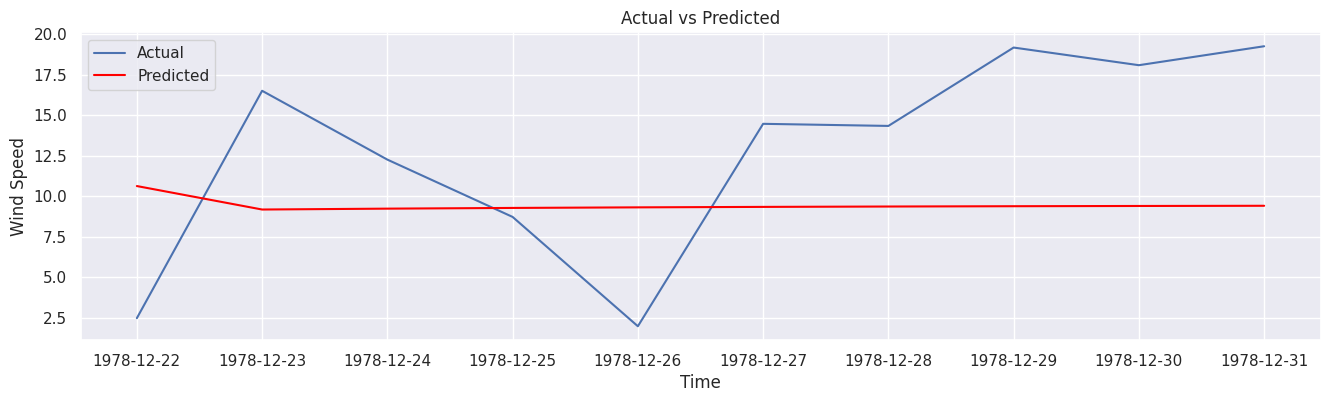

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(test["WIND"],label="Actual")
plt.plot(arma_pred,color="red",label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Wind Speed')
plt.legend(loc='upper left')
plt.show()

Bad forecast on test data.Just straight line no pattern captured. What we need is to create reasonable and good forecasts on the test set and minimize the AIC and RMSE.

Let’s try with seasonal parameters.

### SARIMA

In our initial analysis, we observed approximately 8 peaks every 3 months (or about every 90 days). This suggests a seasonality of more than 7 days. Given this, the seasonal period s in the SARIMA model would likely fall between 8 to 11.

From the Autocorrelation Function (ACF) plot, it appears that there are no significant autocorrelations at the seasonal lags, suggesting that the seasonal moving average order Q could be 0.

From the Partial Autocorrelation Function (PACF) plot, we see significant partial autocorrelations at the seasonal lags, suggesting that the seasonal autoregressive order P could be 1 or 2.

However, these are just initial estimates based on the rule of thumb. The actual order may vary based on the data. It’s always a good idea to try different orders, compare the model’s performance, and select the best model based on appropriate metrics such as AIC, BIC or LLR.

In [ ]:
model_s_1 = SARIMAX(train["WIND"],order=(1,0,2),seasonal_order=(1,0,0,9))
results_sarima_1 = model_s_1.fit()
results_sarima_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               WIND   No. Observations:                  355
Model:             SARIMAX(1, 0, 2)x(1, 0, [], 9)   Log Likelihood               -1010.968
Date:                            Wed, 14 Feb 2024   AIC                           2031.936
Time:                                    20:41:47   BIC                           2051.297
Sample:                                01-01-1978   HQIC                          2039.639
                                     - 12-21-1978                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9979      0.003    378.252      0.000       0.993       1.003
ma.L1         -0.4087      0.046     -8.827      0.000      -0.499      -0.318
ma.L2         -0.3997      0.048     -8.328      0.000      -0.494      -0.306
ar.S.L9       -0.1328      0.056     -2.359      0.018      -0.243      -0.022
sigma2        17.2676      1.251     13.807      0.000      14.816      19.719
===================================================================================
Ljung-Box (L1) (Q):                   0.90   Jarque-Bera (JB):                 6.67
Prob(Q):                              0.34   Prob(JB):                         0.04
Heteroskedasticity (H):               0.91   Skew:                             0.29
Prob(H) (two-sided):                  0.61   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Let's try other models:

In [ ]:
model_s_2 = SARIMAX(train["WIND"],order=(1,0,2),seasonal_order=(2,0,0,9))
results_sarima_2 = model_s_2.fit()
results_sarima_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               WIND   No. Observations:                  355
Model:             SARIMAX(1, 0, 2)x(2, 0, [], 9)   Log Likelihood               -1010.909
Date:                            Wed, 14 Feb 2024   AIC                           2033.818
Time:                                    20:41:53   BIC                           2057.050
Sample:                                01-01-1978   HQIC                          2043.060
                                     - 12-21-1978                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9981      0.003    398.061      0.000       0.993       1.003
ma.L1         -0.4083      0.046     -8.880      0.000      -0.498      -0.318
ma.L2         -0.4037      0.048     -8.388      0.000      -0.498      -0.309
ar.S.L9       -0.1354      0.056     -2.402      0.016      -0.246      -0.025
ar.S.L18      -0.0197      0.050     -0.390      0.697      -0.119       0.079
sigma2        17.2595      1.252     13.789      0.000      14.806      19.713
===================================================================================
Ljung-Box (L1) (Q):                   0.89   Jarque-Bera (JB):                 6.91
Prob(Q):                              0.34   Prob(JB):                         0.03
Heteroskedasticity (H):               0.91   Skew:                             0.29
Prob(H) (two-sided):                  0.63   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
model_s_3 = SARIMAX(train["WIND"],order=(1,0,2),seasonal_order=(1,1,0,8))
results_sarima_3 = model_s_3.fit()
results_sarima_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               WIND   No. Observations:                  355
Model:             SARIMAX(1, 0, 2)x(1, 1, [], 8)   Log Likelihood               -1055.308
Date:                            Wed, 14 Feb 2024   AIC                           2120.617
Time:                                    20:41:54   BIC                           2139.863
Sample:                                01-01-1978   HQIC                          2128.280
                                     - 12-21-1978                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6150      0.156      3.953      0.000       0.310       0.920
ma.L1         -0.0110      0.170     -0.065      0.949      -0.345       0.323
ma.L2         -0.1156      0.109     -1.061      0.289      -0.329       0.098
ar.S.L8       -0.4400      0.044    -10.038      0.000      -0.526      -0.354
sigma2        25.4963      1.891     13.480      0.000      21.789      29.204
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 4.51
Prob(Q):                              0.95   Prob(JB):                         0.10
Heteroskedasticity (H):               0.81   Skew:                             0.27
Prob(H) (two-sided):                  0.25   Kurtosis:                         3.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Based on the Akaike Information Criterion (AIC) score, the SARIMA(1,0,2)(1,0,0,9) model appears to provide the best fit for our data. However, to further validate this and compare it with other potential models, we should also conduct a Likelihood Ratio (LLR) test. The LLR test will allow us to statistically compare the goodness of fit between nested models and help confirm if SARIMA(1,0,2)(1,0,0,9) indeed offers the optimal balance between model complexity and explanatory power.

In [ ]:
#LLR test between SARIMA(1,0,2)(1,0,0,9)  and SARIMA(1,0,2)(2,0,0,9)
LLR_test(model_s_1,model_s_2)

0.73

The p value is  greater than 0.05 so we fail to reject the null hypothesis. This means the more complex model SARIMA(1,0,2)(2,0,0,9) does not offer any significant enhancement in fitting the data. Therefore, we will adhere to the simpler model.SARIMA(1,0,2)(1,0,0,9)

In [ ]:
predictions = results_sarima_1.predict(start=start, end=end)


In [ ]:
#calculate RMSE
rmse = sqrt(mean_squared_error(test["WIND"],predictions))
print('RMSE: ', rmse)

RMSE:  7.101606038901606


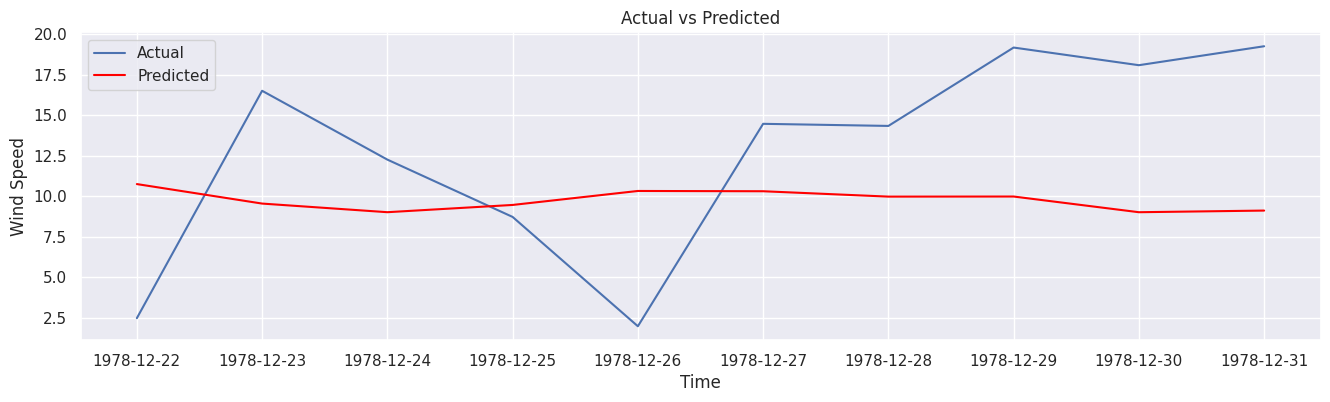

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(test["WIND"],label="Actual")
plt.plot(predictions,color="red",label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Wind Speed')
plt.legend(loc='upper left')
plt.show()

While there is a slight enhancement in the forecast lines, we do not observe any significant improvements in the Root Mean Square Error (RMSE) or the Akaike Information Criterion (AIC) values. These metrics are crucial for assessing the model’s performance and complexity, respectively. Given these observations, it would be worthwhile to explore the SARIMAX model, which incorporates an additional exogenous component, to see if it provides a better fit for our data.

###SARIMAX

In [ ]:
# define the exogenous variables
exog_var_train = train[['RAIN','T.MAX','T.MIN','T.MIN.G']].ffill()
exog_var_test  = test[['RAIN','T.MAX','T.MIN','T.MIN.G']].ffill()

In [ ]:
model_s_x = SARIMAX(train["WIND"],order=(1,0,2),seasonal_order=(1,0,0,9),exog=exog_var_train)
results_sarimax = model_s_x.fit()
results_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               WIND   No. Observations:                  355
Model:             SARIMAX(1, 0, 2)x(1, 0, [], 9)   Log Likelihood                -996.414
Date:                            Wed, 14 Feb 2024   AIC                           2010.829
Time:                                    20:53:57   BIC                           2045.678
Sample:                                01-01-1978   HQIC                          2024.693
                                     - 12-21-1978                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
RAIN          -0.0125      0.038     -0.326      0.745      -0.088       0.063
T.MAX         -0.1947      0.109     -1.791      0.073      -0.408       0.018
T.MIN          0.0369      0.164      0.225      0.822      -0.284       0.358
T.MIN.G        0.3104      0.105      2.951      0.003       0.104       0.516
ar.L1          0.9984      0.002    417.511      0.000       0.994       1.003
ma.L1         -0.4187      0.047     -8.917      0.000      -0.511      -0.327
ma.L2         -0.3786      0.049     -7.687      0.000      -0.475      -0.282
ar.S.L9       -0.1064      0.058     -1.821      0.069      -0.221       0.008
sigma2        15.8967      1.192     13.333      0.000      13.560      18.234
===================================================================================
Ljung-Box (L1) (Q):                   0.60   Jarque-Bera (JB):                 2.12
Prob(Q):                              0.44   Prob(JB):                         0.35
Heteroskedasticity (H):               0.92   Skew:                             0.16
Prob(H) (two-sided):                  0.65   Kurtosis:                         3.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
predictions_x = results_sarimax.predict(start=start, end=end,exog=exog_var_test)
#calculate RMSE
rmse = sqrt(mean_squared_error(test["WIND"],predictions_x))
print('RMSE: ', rmse)
print("AIC: " ,results_sarimax.aic)

RMSE:  6.403081881848351
AIC:  2010.8288492300892


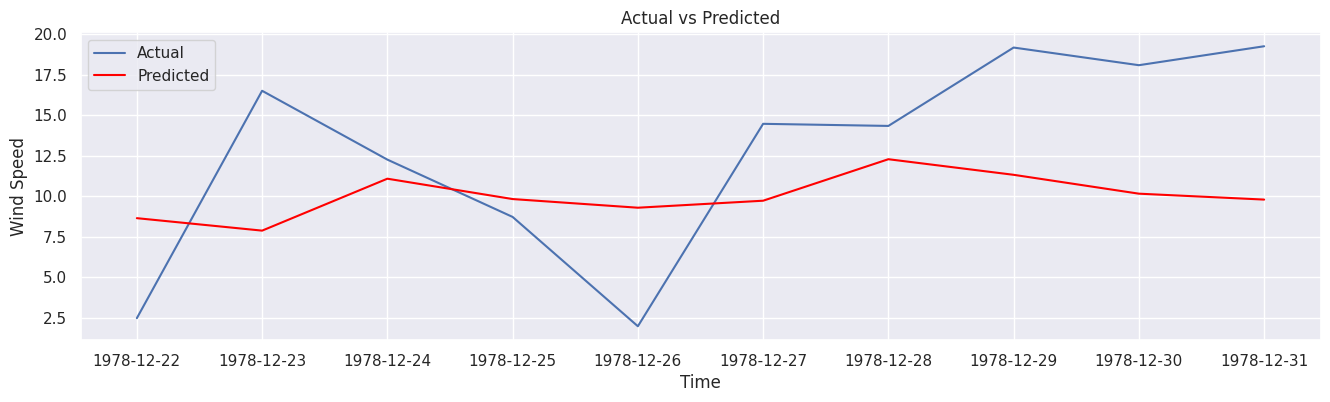

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(test["WIND"],label="Actual")
plt.plot(predictions_x,color="red",label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Wind Speed')
plt.legend(loc='upper left')
plt.show()

The performance of our model has shown noticeable improvement! Both the Akaike Information Criterion (AIC) and the Root Mean Square Error (RMSE) scores have improved compared to the SARIMA model, indicating a better balance between model fit and complexity, and more accurate predictions respectively.

However, upon examining the forecast line, it appears that the model struggles to accurately capture the trends in the data. In fact, there are periods where the model’s predictions are contrary to the actual observed trends. This suggests that while our model’s overall error metrics have improved, its ability to capture the underlying patterns in the data may need further refinement.

Let's try AutoArima:

### Auto Arima

In [ ]:
model_auto = pm.auto_arima(train["WIND"])
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  355
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -1004.229
Date:                Wed, 14 Feb 2024   AIC                           2016.458
Time:                        20:42:31   BIC                           2031.935
Sample:                    01-01-1978   HQIC                          2022.616
                         - 12-21-1978                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4230      0.089      4.755      0.000       0.249       0.597
ma.L1         -0.7962      0.094     -8.498      0.000      -0.980      -0.613
ma.L2         -0.1624      0.087     -1.876      0.061      -0.332       0.007
sigma2        16.9623      1.238     13.700      0.000      14.536      19.389
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 6.87
Prob(Q):                              0.91   Prob(JB):                         0.03
Heteroskedasticity (H):               0.85   Skew:                             0.29
Prob(H) (two-sided):                  0.39   Kurtosis:                         3.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
model_auto = pm.auto_arima(
    train["WIND"],exogenous=exog_var_train,m=9,max_order='none',max_p=7,
    max_q=7, max_d = 2, max_P = 4, max_Q = 4, max_D = 2,maxiter = 50, alpha = 0.05, n_jobs = -1, trend = 'ct'
    )
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  355
Model:             SARIMAX(2, 1, 2)x(2, 0, [], 9)   Log Likelihood               -1001.367
Date:                            Wed, 14 Feb 2024   AIC                           2020.733
Time:                                    20:44:17   BIC                           2055.557
Sample:                                01-01-1978   HQIC                          2034.588
                                     - 12-21-1978                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0411      0.028     -1.486      0.137      -0.095       0.013
drift          0.0002      0.000      1.645      0.100   -4.22e-05       0.000
ar.L1         -0.0920      0.242     -0.381      0.703      -0.566       0.382
ar.L2          0.3038      0.160      1.903      0.057      -0.009       0.617
ma.L1         -0.2740      0.226     -1.212      0.225      -0.717       0.169
ma.L2         -0.6771      0.221     -3.063      0.002      -1.110      -0.244
ar.S.L9       -0.1043      0.057     -1.841      0.066      -0.215       0.007
ar.S.L18      -0.0103      0.052     -0.197      0.844      -0.113       0.092
sigma2        16.0070      1.226     13.057      0.000      13.604      18.410
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):                 6.14
Prob(Q):                              0.62   Prob(JB):                         0.05
Heteroskedasticity (H):               0.88   Skew:                             0.28
Prob(H) (two-sided):                  0.48   Kurtosis:                         3.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
predictions_auto = model_auto.predict(start=start, end=end,exog=exog_var_test)
#calculate RMSE
rmse = sqrt(mean_squared_error(test["WIND"],predictions_auto))
print('RMSE: ', rmse)

RMSE:  6.142305358598936


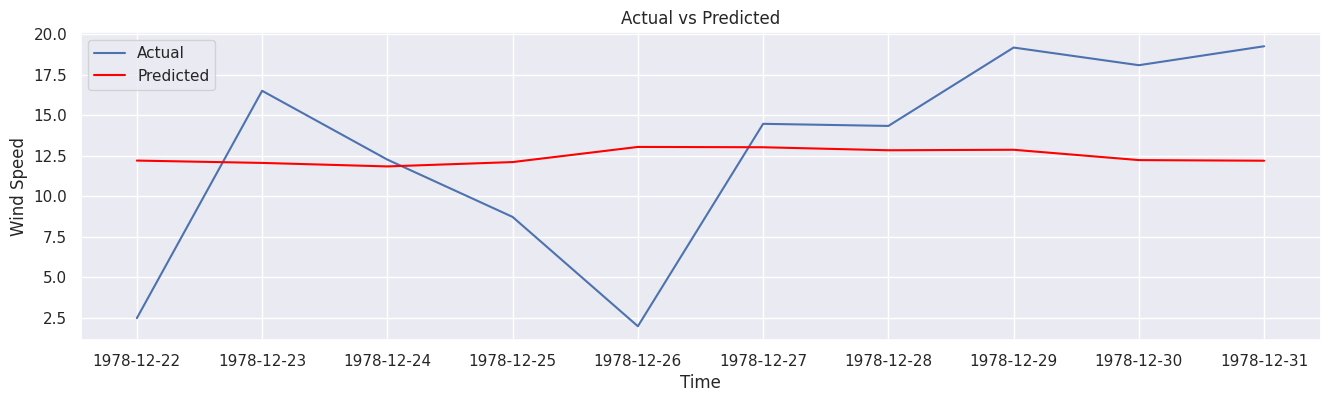

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(test["WIND"],label="Actual")
plt.plot(predictions_auto,color="red",label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Wind Speed')
plt.legend(loc='upper left')
plt.show()

Based on the previous results, the SARIMA model outperforms the AutoARIMA model in terms of both the Akaike Information Criterion (AIC) and the Root Mean Squared Error (RMSE). This indicates that the SARIMA model provides a better fit to the data and makes more accurate predictions. However the SARIMA model’s forecast line could still be improved to capture more trends in the data. Therefore, our next step will be to fine-tune the SARIMA model parameters to enhance its ability to identify and replicate these trends in its forecasts

## Fine tuning

In [62]:
# Define the p, d, q, P, D, Q, and s parameters to take any value between 0 and 4
p = d = q = P = D = Q = range(0,2)
s = range(8,10)
# Generate all different combinations of p, d, q, P, D, Q, and s
pdq = list(itertools.product(p,d,q))
seasonal_pdq = list(itertools.product(P,D,Q,s))
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
best_model = None
# Grid search
for param in pdq:
  for seasonal_param in seasonal_pdq:
    temp_model = SARIMAX(train["WIND"],order=param,seasonal_order=seasonal_param,exog=exog_var_train)
    temp_fit=temp_model.fit()
    # Compute AIC to find the best model
    temp_aic = temp_fit.aic
    if temp_aic < best_aic:
      best_aic = temp_aic
      best_pdq = param
      best_seasonal_pdq = seasonal_param
      best_model = temp_fit
print("Best SARIMAX{}x{} model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(1, 0, 0)x(1, 1, 1, 9) model - AIC:1973.3065907797632


In [63]:
best_pred = best_model.predict(start = start, end = end, exog=exog_var_test)
rmse = sqrt(mean_squared_error(test["WIND"],best_pred))
print('RMSE: ', rmse)

RMSE:  5.385099378991874


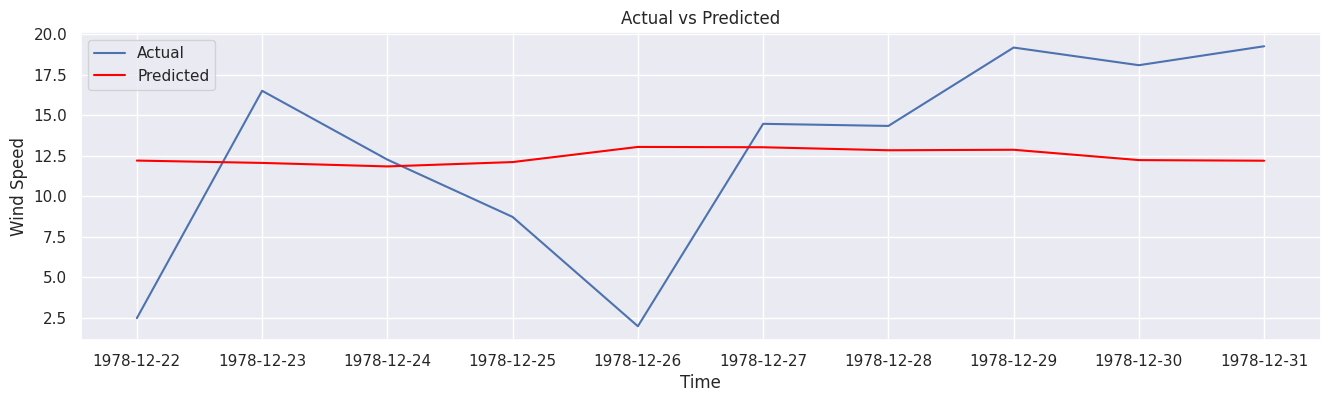

In [67]:
plt.figure(figsize=(16,4))
plt.plot(test["WIND"],label="Actual")
plt.plot(predictions_auto,color="red",label='Predicted')
plt.title('Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Wind Speed')
plt.legend(loc='upper left')
plt.show()

I have evaluated two SARIMAX models. The first model SARIMAX(1,0,0)(1,1,1,9)exhibits lower values for both the Akaike Information Criterion (AIC) and the Root Mean Squared Error (RMSE), indicating a statistically more efficient fit to the data. However, its forecast line does not capture the trend in the data well and appears as a relatively straight line with minor fluctuations.

The second model SARIMAX(1,0,2)(1,0,0,9), while having a slightly higher AIC and RMSE, provides a forecast line that captures the underlying trends in the data more effectively.

The choice between these models depends on the specific requirements of the analysis. If minimizing the AIC and RMSE is the priority, indicating a preference for a model that explains the data with fewer parameters, then the first model would be the preferred choice. However, if the ability to capture and predict trends in the data is more important, then the second model may be more suitable despite its higher AIC and RMSE

I will continue with the model has lower AIC and RMSE scores which is SARIMAX(1,0,0)(1,1,1,9)

##Residual Analysis


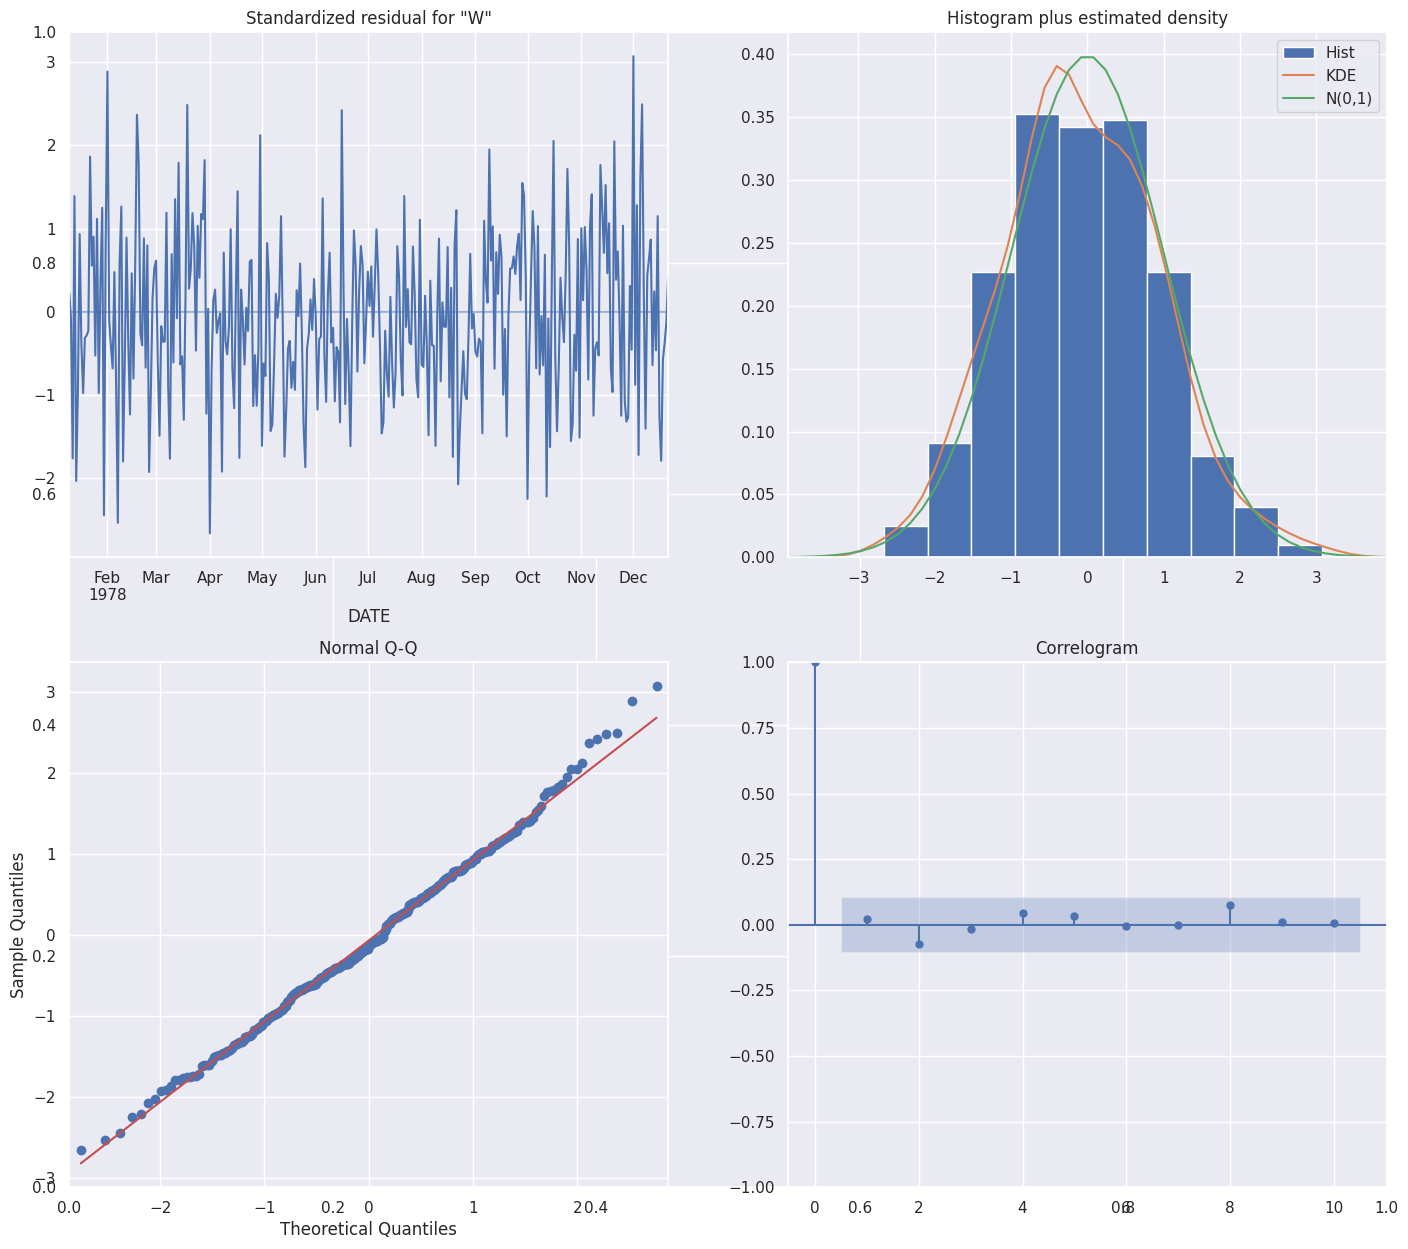

In [65]:
fig,ax = plt.subplots(figsize=(17,15))
best_model.plot_diagnostics(fig=fig);

The residuals of our model show no patterns or trends, have constant variance, follow a normal distribution, and exhibit no autocorrelation. These are all positive signs indicating that our model is well-specified and provides reliable forecasts.

#Forecast

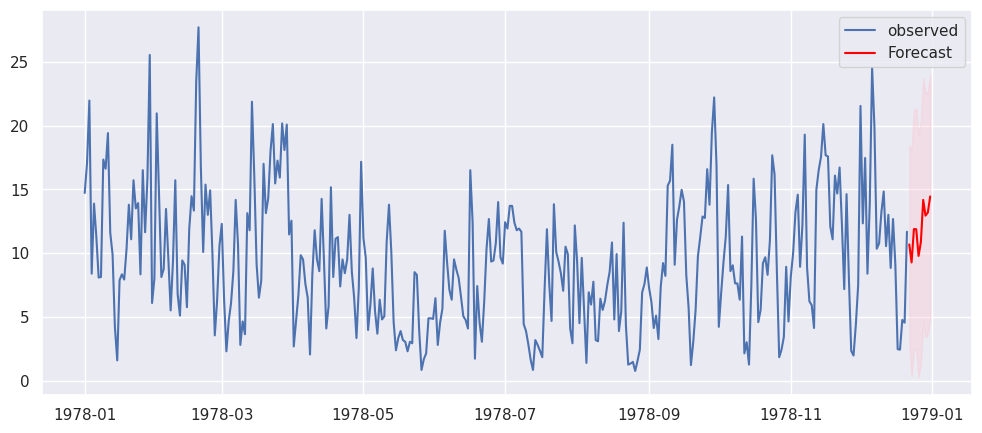

In [75]:
# Define the number of steps to forecast
n_steps = 10
# Generate forecast
forecast = best_model.get_forecast(steps=n_steps,exog=exog_var_test)
# Get confidence intervals of forecasts
confidence_intervals = forecast.conf_int()
# Plot actual data
plt.figure(figsize=(12, 5))
plt.plot(train["WIND"], label='observed')
# Plot forecasted data
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, color='red', label='Forecast')
# Shade the area between your confidence intervals
plt.fill_between(confidence_intervals.index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1], color='pink', alpha=.3)

plt.legend()
plt.show()
